# Getting Started with Pytorch WideDeep

`pytorch-widedeep` is a flexible and modular way to build deep learning models. You can start with multimodal data (wide) while using deep learning to find complex relationships in your data (deep).  An example use case is predicting the value of a house based on images of the house, tabular data (e.g., number of rooms, floor area), and a text data (e.g, a detailed description).  With `pytorch-widedeep` you can bring all those disparate types of data into one deep learning model!

### Is this package right for you?

This notebook focuses on a deep learning approach to tabular data.  If you are just getting started, you are probably better off using an approach like gradient boosted machines, which typically perform better on tabular data.  Check out [Javier's post](https://jrzaurin.github.io/infinitoml/2021/05/28/pytorch-widedeep_iv.html) for a comparison of GBM versus deep learning.  However, for people with larger datasets, more complex features, multiclass, multitarget, or multitask, using a deep learning approach has benefits, check out how [Pinterest](https://medium.com/pinterest-engineering/how-we-use-automl-multi-task-learning-and-multi-tower-models-for-pinterest-ads-db966c3dc99e) or [Lyft](https://twimlai.com/causal-models-in-practice-at-lyft-with-sean-taylor/) have moved to deep learning models.

The notebook focuses on `pytorch-widedeep` which I like, but the pytorch ecoysystem has lots of other great packages I would recommend including [fast.ai](https://docs.fast.ai/), [pytorch-tabular](https://pytorch-tabular.readthedocs.io/en/latest/), and [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/latest/).    

### How to use this notebook

The notebook is structured to walk you through a typical workflow of preprocessing your data, defining a model, training a model, and then getting predictions. We start with a simple MLP with TabMLP and then move to more complex approaches like the TabResnet, and TabTransformer. Links to additional documentation and academic papers are also included.

The notebook is intended to be an interactive way to explore the pytorch models. Take time to look at each object that is created and understand what is happening at every step. This notebook is not intended as boilerplate code for building a production mode. Finally, this notebook is just the start. There are plenty of other [example notebooks](https://github.com/jrzaurin/pytorch-widedeep/tree/master/examples) that cover more advanced uses like [combining images and text](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/05_Regression_with_Images_and_Text.ipynb). 

### Install and Data Prep

[Click here to open in Google Colab](https://colab.research.google.com/github/rajshah4/widedeep_notebooks/blob/main/Quick_Start_WideDeep.ipynb).  

Installing pytorch-widedeep is a an important first step. After, that we will import in the necessary libraries for this notebook.

In [1]:
##Packages to install when using Google Colab
#!pip install pytorch-widedeep
#!pip install captum
#You should then restart the runtime

In [2]:
import numpy as np
import pandas as pd
import torch

from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.models import Wide, TabMlp, TabResnet, TabTransformer, WideDeep, TabFastFormer, TabPerceiver
from pytorch_widedeep.metrics import Accuracy, Precision

from captum.attr._core.feature_permutation import FeaturePermutation

import matplotlib.pyplot as plt

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


The dataset for this notebooks is the [UCI Adult Census](https://archive.ics.uci.edu/ml/datasets/adult) dataset. This dataset was chosen because it has a mix of numerical and categorical features.  Let's prepare our data by putting all of the features and our target into one pandas dataframe.

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                 'capital_gain', 'capital_loss', 'hours_per_week', 
                 'native_country', 'income']

df = pd.read_csv('adult.data', header=None, names=names, na_values=['?', ' ?'])
#create a binary target
df['income_label'] = (df["income"].apply(lambda x: ">50K" in x)).astype(int)
df.drop('income', axis=1, inplace=True)
df.head()

--2021-09-28 17:27:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.18’

adult.data.18       100%[===================>]   3.79M  5.28MB/s    in 0.7s    

2021-09-28 17:27:11 (5.28 MB/s) - ‘adult.data.18’ saved [3974305/3974305]



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### Preprocessing the data

For data with high cardinality categoricals, text, image data  . .. or anything that is wide, we applying some preprocessing.  The simplest approach `Wide` is shown below for categoricals.  Here we implement a liner layer as an Embedding layer plus a bias.  When working with text use `DeepText` or with images use `DeepImage`.  There is also `DeepTabular` when you want to build XYZ on tabular datasets.  The examples section includes more detailed notebooks on [preprocessing](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/01_Preprocessors_and_utils.ipynb).

Here we define the categoricval features that should be treated as wide.  We also perform additional feature engineering by indicating that `education` and `occupation` are crossed columns.  This will manually create interaction features between the two features.  The WidePreprocessor label encodes all the categorical features.

In [4]:
wide_cols = ['education', 'relationship','workclass','occupation','native_country','sex']
crossed_cols = [('education', 'occupation'), ('native_country', 'occupation')]

In [5]:
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=crossed_cols)
X_wide = wide_preprocessor.fit_transform(df)

For `DeepTabular`, we define columns with categorical features that should create embeddings with `cat_embed_cols` and features that are continious numerical with `continuous_cols`.  The resulting dataset gets label-encoded for the categorical columns and normalizes the numerical ones.

In [6]:
cat_embed_cols = [('education',16), ('relationship',8), ('workclass',16), ('occupation',16),('native_country',16)]
continuous_cols = ["age","hours_per_week"]


In [7]:
tab_preprocessor = TabPreprocessor(embed_cols=cat_embed_cols, continuous_cols=continuous_cols)
X_tab = tab_preprocessor.fit_transform(df)

In [8]:
# TARGET
target_col = 'income_label'
target = df[target_col].values

### Modeling Setup

Modeling requires bringing together the preprocessed components and applying one of the deep tabular models.  There is considerable flexibility in the library for how you are doing this.  There is everything from the very simple `TabMlp` to the well-known `TabNet` to more cutting edge approaches like `Perceiver`, and `FastFormer`.  To see more examples, check out the notebook that focuses on [deeptabular models](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/02_2_deeptabular_models.ipynb) or the [transformer models](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/10_The_Transformer_Family.ipynb).

For this notebook, we start by taking our wide preprocessed dataset and putting it through a very simple MLP that represents the categorical features and concatenates the continuous features.  You can view the model object to see the structure of the model. 

In [9]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
deeptabular = TabMlp(mlp_hidden_dims=[64,32], 
                      column_idx=tab_preprocessor.column_idx,
                      embed_input=tab_preprocessor.embeddings_input,
                      continuous_cols=continuous_cols)
model = WideDeep(wide=wide, deeptabular=deeptabular)

### Training
Once the model is built, we just need to compile it and run it.  The Trainer is where you would look for the typical options for training a model.

In [10]:
mlp_model = Trainer(model, objective='binary', metrics=[Accuracy, Precision])

In [11]:
mlp_model.fit(X_wide=X_wide, X_tab=X_tab, target=target, n_epochs=5, batch_size=64, val_split=0.2)

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
valid: 100%|██████████| 102/102 [00:00<00:00, 170.07it/s, loss=0.35, metrics={'acc': 0.8319, 'prec': 0.687}]


Let's try more models.  As you can see, you can run a wide and deep model in just a few lines of code. The simple MLP approach provided a logloss of 0.349.  
  
Let's now walk through some more advanced approaches starting with the `FT-Transformer` as the `deeptabular` component. This model uses a simple transformer approach for tabular data explained at [https://arxiv.org/abs/2106.11959](https://arxiv.org/abs/2106.11959). It does require slightly different preprocessing and combines a deep approach with a deep tabular approach.

In [12]:

cat_embed_cols_for_transformer = [el[0] for el in cat_embed_cols]
tab_preprocessor = TabPreprocessor(embed_cols=cat_embed_cols_for_transformer, 
                                   continuous_cols=continuous_cols, 
                                   for_transformer=True, 
                                   with_cls_token = True)
X_tab = tab_preprocessor.fit_transform(df)

In [13]:
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)
deeptabular = TabTransformer(column_idx=tab_preprocessor.column_idx,
                             embed_input=tab_preprocessor.embeddings_input,
                             continuous_cols=continuous_cols, 
                             embed_continuous = True, 
                             embed_continuous_activation = "relu")
model = WideDeep(wide=wide, deeptabular=deeptabular)
tabt_model = Trainer(model, objective='binary', metrics=[Accuracy, Precision])
tabt_model.fit(X_wide=X_wide, X_tab=X_tab, target=target, n_epochs=5, batch_size=512, val_split=0.2)

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
valid: 100%|██████████| 13/13 [00:00<00:00, 29.14it/s, loss=0.362, metrics={'acc': 0.8353, 'prec': 0.6882}]


Let's now try a few of the cutting edge models, such as `Perceiver` and `TabFastFormer`.  [DeepMind's Perceiver](https://arxiv.org/pdf/2103.03206.pdf) is built for handling multimodel data.  `TabFastFormer` is an adaptation of [Fastformer: Additive Attention Can Be All You Need](https://arxiv.org/pdf/2108.09084.pdf). As you will see, Fastformer gives the lowest loss.

In [14]:
tabperceiver = TabPerceiver(
    column_idx=tab_preprocessor.column_idx,
    embed_input=tab_preprocessor.embeddings_input,
    continuous_cols=tab_preprocessor.continuous_cols, 
    n_perceiver_blocks=1, 
    n_latent_blocks=3, 
    n_latent_heads=2, 
    n_latents=6,
    latent_dim=32,
)
model = WideDeep(deeptabular=tabperceiver)
perc_model = Trainer(model, objective='binary', metrics=[Accuracy])
perc_model.fit(X_tab=X_tab, target=target, n_epochs=5, batch_size=256, val_split=0.2)

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
valid: 100%|██████████| 26/26 [00:00<00:00, 42.92it/s, loss=0.347, metrics={'acc': 0.8382}]


In [15]:
tabfastformer = TabFastFormer(column_idx=tab_preprocessor.column_idx,
              embed_input=tab_preprocessor.embeddings_input,
              continuous_cols=tab_preprocessor.continuous_cols, 
              n_blocks=2, n_heads=4,             
            )
model = WideDeep(deeptabular=tabfastformer)
fasttab_model = Trainer(model, objective='binary', metrics=[Accuracy])
fasttab_model.fit(X_tab=X_tab, target=target, n_epochs=5, batch_size=256, val_split=0.2)

/Users/rajiv.shah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/__init__.py:1102: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
valid: 100%|██████████| 26/26 [00:00<00:00, 64.24it/s, loss=0.344, metrics={'acc': 0.8369}]


### Explainability

Explainability is very important for understanding how your model is working and getting others to trust your model.  All of these models will work with traditional model agnostic explainablity techniques like permutation based feature importance, partial dependence, and Shap explanations.  Additionally it's possible to extract our the attention weights to better understand what the model is focused on.  You can find this in the companion notebook location XYZ

In [21]:

feature_perm = FeaturePermutation(model.deeptabular.eval())
attr_fic = feature_perm.attribute(torch.from_numpy(X_tab),target=0)  ##Run here against training data
attr_fic_sum = torch.div(torch.sum((np.absolute(attr_fic)),0),len(attr_fic))
attr_fic_sum

tensor([0.0000, 0.6454, 1.4507, 0.1671, 0.7164, 0.0971, 0.7971, 0.6541])

Feature Importance for Permutation Importance
['cls_token', 'education', 'relationship', 'workclass', 'occupation', 'native_country', 'age', 'hours_per_week']
cls_token :  0.000
education :  0.645
relationship :  1.451
workclass :  0.167
occupation :  0.716
native_country :  0.097
age :  0.797
hours_per_week :  0.654


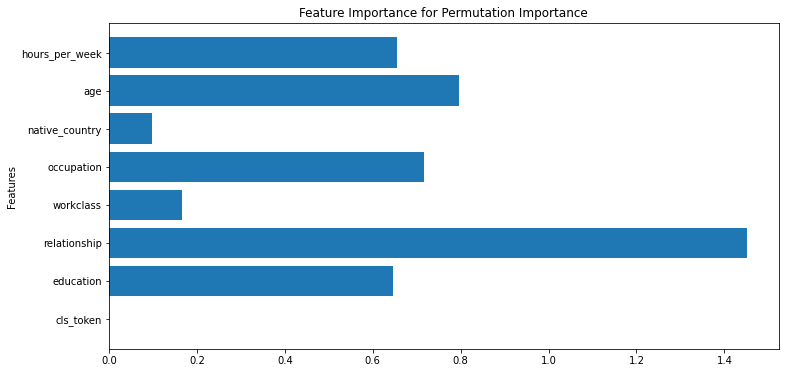

In [33]:
# Helper method to print importances and visualize feature importance

def visualize_importances(feature_names, importances, title="Feature Importance for Permutation Importance", plot=True, axis_title="Features"):
    print(title)
    print (feature_names)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.barh(x_pos, importances, align='center')
        plt.yticks(x_pos, feature_names, wrap=True)
        plt.ylabel(axis_title)
        plt.title(title)
fnl = list(tab_preprocessor.column_idx.keys())
visualize_importances(fnl, attr_fic_sum.numpy())

### Predictions and Saving your model

Once you have trained the model, you can always run predictions against it for your new data.  Here is a simple command for getting probabilities back from a classification model.

In [36]:
results = fasttab_model.predict_proba(X_tab=X_tab)
results

predict: 100%|██████████| 128/128 [00:01<00:00, 90.72it/s] 


array([[9.68174100e-01, 3.18259038e-02],
       [4.96614397e-01, 5.03385603e-01],
       [9.90554571e-01, 9.44540463e-03],
       ...,
       [9.88520682e-01, 1.14793219e-02],
       [9.99272227e-01, 7.27771898e-04],
       [2.80827999e-01, 7.19172001e-01]])

Here are some commands for saving preprocessing steps, the model, and training history.  There are example notebooks that cover [saving and loading a model](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/08_save_and_load_model_and_artifacts.ipynb).

In [37]:
import pickle

#save preprocessing
with open('tab_preproc.pkl', 'wb') as dp:
    pickle.dump(tab_preprocessor, dp)

#save the model and training history
fasttab_model.save(path ="",model_filename="model_saved.pt")